*Note that this notebook is currently unfinished and only BERTopic has been implemented.*

## Comparing topic modelling techniques

This notebook compares two different advanced topic modelling techniques in terms of how well they represent our PFD data: **BERTopic** and **Top2Vec**.<br><br>


1. **BERTopic**

BERTopic uses BERT embeddings and clustering algorithms to discover topics. Topics are characterised by dense clusters of semantically similar embeddings, identified through dimensionality reduction and clustering. Although not originally supported, v0.13 (January 2023) also allows us to approximate a probabilistic topic distribution for each report via '.approximate_distribution'.<br><br>


2. **Top2Vec**

Topics in Top2Vec are characterised by dense clusters of document and word embeddings. These clusters are identified in a joint embedding space, where both documents and words are represented. It similarly allows for multiple topics per document; this is achieved through the proximity of document embeddings to multiple topic vectors in the semantic space.

Top2Vec uses deep learning-based embeddings (e.g., Doc2Vec, Universal Sentence Encoder) to capture the semantic relationships in the text.<br><br><br>


Neither BERTopic nor Top2Vec require us to pre-specify our number of topics, unlike more classic approaches such as LDA.<br><br><br>



In [1]:
import pandas as pd
import numpy as np

# Read json file
data = pd.read_json('../Data/tokenised.json', orient='split')
data

,URL,CleanContent,ProcessedContent,ProcessedWords,ProcessedSentences,WordEmbeddings
0,https://www.judiciary.uk/prevention-of-future-...,Pre-amble Mr Larsen was a 52 year old male wi...,pre amble mr larsen year old male history ment...,"[pre, amble, mr, larsen, year, old, male, hist...","[[pre, amble, mr, larsen, year, old, male, his...","[[0.0107421875, 0.0791015625, 0.0434570312, -0..."
1,https://www.judiciary.uk/prevention-of-future-...,(1) The process for triaging and prioritising ...,process triaging prioritise ambulance attendan...,"[process, triaging, prioritise, ambulance, att...","[[process, triaging, prioritise, ambulance, at...","[[0.1103515625, 0.255859375, 0.0341796875, -0...."
2,https://www.judiciary.uk/prevention-of-future-...,(1) There are questions and answers on Quora’s...,question answer quora website provide informat...,"[question, answer, quora, website, provide, in...","[[question, answer, quora, website, provide, i...","[[0.1010742188, 0.0991210938, -0.0375976562, 0..."
3,https://www.judiciary.uk/prevention-of-future-...,(1) The prison service instruction (PSI) 64/20...,prison service instruction psi set procedure m...,"[prison, service, instruction, psi, set, proce...","[[prison, service, instruction, psi, set, proc...","[[-0.0356445312, -0.142578125, 0.27734375, -0...."
4,https://www.judiciary.uk/prevention-of-future-...,My principal concern is that when a high-risk ...,principal concern high risk mental health pati...,"[principal, concern, high, risk, mental, healt...","[[principal, concern, high, risk, mental, heal...","[[0.046875, -0.23046875, 0.328125, -0.16308593..."
...,...,...,...,...,...,...
392,https://www.judiciary.uk/prevention-of-future-...,1. Brenda Morris was allowed weekend leave on ...,brenda morris allow weekend leave basis partne...,"[brenda, morris, allow, weekend, leave, basis,...","[[brenda, morris, allow, weekend, leave, basis...","[[0.1376953125, -0.0505371094, 0.154296875, 0...."
393,https://www.judiciary.uk/prevention-of-future-...,Barts and the London 1. Whilst it was clear to...,bart london whilst clear evidence heard inques...,"[bart, london, whilst, clear, evidence, heard,...","[[bart, london, whilst, clear, evidence, heard...","[[-0.0341796875, -0.0971679688, -0.0356445312,..."
394,https://www.judiciary.uk/prevention-of-future-...,1. Piotr Kucharz was a Polish gentleman who co...,piotr kucharz polish gentleman commence living...,"[piotr, kucharz, polish, gentleman, commence, ...","[[piotr, kucharz, polish, gentleman, commence,...","[[-0.0346233919, 0.0211960897, 0.0161410663, 0..."
395,https://www.judiciary.uk/prevention-of-future-...,Camden and Islington Trust 1. It seemed from t...,camden islington trust seem evidence heard cam...,"[camden, islington, trust, seem, evidence, hea...","[[camden, islington, trust, seem, evidence, he...","[[-0.052734375, -0.0030517578000000003, -0.007..."


## 1. BERTopic

Below, we perform an initial implementation of BERTopic. 

I found that the most meaningful representation of the text was presented when we looked at 3-word phrases (triagrams) only. However, the model can also be instructed to find a mixture of unigrams and bigrams instead.

In BERTopic, results can vary depending on the embedding model used. The following models were experimented with in building this notebook:
* all-mpnet-base-v2
* multi-qa-mpnet-base-dot-v1"

A complete list of embedding models can be found [here](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html).

In [2]:
from bertopic import BERTopic
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer

# Create a list of report contents
reports = data['ProcessedContent'].tolist()

# Initialise the vectorizer 
# ...The ngram_range parameter specifies the range of n-grams to extract
# ...1 extracts single words (unigrams), 2 extracts 2-word phrases (bigrams), 3 extracts 3-word phrases (trigrams).
vectorizer_model = CountVectorizer(ngram_range = (2, 3))


# Create a UMAP model
umap_model = UMAP(n_neighbors=10, 
                  n_components=5,
                  min_dist=0.0,
                  random_state=230624)


# Generate a topic model with 10 top terms
bertopic_model = BERTopic(embedding_model = "all-mpnet-base-v2",
                          top_n_words = 5,
                          n_gram_range = (2, 3),
                          #nr_topics = 10,
                          min_topic_size = 6,
                          vectorizer_model = vectorizer_model,
                          calculate_probabilities = True,
                          umap_model = umap_model) 

# Fit the model to data
topics, probabilities = bertopic_model.fit_transform(reports)

# Find unique topics
unique_topics = set(topics)
num_unique_topics = len(unique_topics)

print(f"Number of unique topics identified: {num_unique_topics}")

# Get topic information
topic_info = bertopic_model.get_topic_info()
print("Topic Info:\n", topic_info)

# Print most frequent topics
bertopic_model.get_topic_freq().head(10)


/home/sam/miniconda3/envs/PFD/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sam/miniconda3/envs/PFD/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sam/miniconda3/envs/PFD/lib/python3.8/site-packages/umap/distances.py:1086: 

Number of unique topics identified: 11
Topic Info:
     Topic  Count                                               Name  \
0      -1     96  -1_mental health_mr larsen_risk assessment_act...   
1       0     59  0_mental health_health service_mental health t...   
2       1     59  1_chief coroner_action take_send copy_send cop...   
3       2     40    2_mental health_guy marsh_hmp guy_hmp guy marsh   
4       3     30  3_risk assessment_child service_united child s...   
5       4     28  4_police officer_british transport police_tran...   
6       5     26       5_mental health_self harm_mr evans_mr harper   
7       6     17  6_care co_care co ordinator_co ordinator_co or...   
8       7     16  7_mental health_self harm_university invite re...   
9       8     16  8_miss zarins_anti depressant_mdt meeting_inve...   
10      9     10  9_mental health_key worker_autistic child_conc...   

                                       Representation  \
0   [mental health, mr larsen, risk as

,Topic,Count
0,-1,96
4,0,59
6,1,59
1,2,40
2,3,30
3,4,28
9,5,26
8,6,17
7,7,16
10,8,16


In [3]:
# Add topics to our data frame
data['Topic'] = topics

# Get the top 10 reports for each topic
top_urls_per_topic = {}

for topic in unique_topics:
    if topic != -1:  # Skip the outlier topic if it exists (BERTopic assigns outliers to "topic -1")
        # Filter data by topic and sort by probability
        topic_data = data[data['Topic'] == topic]
        top_reports = topic_data.nlargest(10, 'Topic')
        top_urls = top_reports['URL'].tolist()
        top_urls_per_topic[f'Topic {topic}'] = top_urls

# Print the URLs of the top 10 reports for each topic
print("For each topic, the top 10 most aligned reports are: ")

for topic, urls in top_urls_per_topic.items():
    print(f"{topic}:")
    for url in urls:
        print(url)
    print("\n")


For each topic, the top 10 most aligned reports are: 
Topic 0:
https://www.judiciary.uk/prevention-of-future-death-reports/benjamin-sulzbacher-prevention-of-future-deaths-report/
https://www.judiciary.uk/prevention-of-future-death-reports/evie-davies-prevention-of-future-deaths-report/
https://www.judiciary.uk/prevention-of-future-death-reports/jason-pulman-prevention-of-future-deaths-report/
https://www.judiciary.uk/prevention-of-future-death-reports/erik-marshall-prevention-of-future-deaths-report/
https://www.judiciary.uk/prevention-of-future-death-reports/axel-price-prevention-of-future-deaths-report/
https://www.judiciary.uk/prevention-of-future-death-reports/sarah-adams-prevention-of-future-deaths-report/
https://www.judiciary.uk/prevention-of-future-death-reports/nicolas-gerasimidis-prevention-of-future-deaths-report/
https://www.judiciary.uk/prevention-of-future-death-reports/rachel-mortimer-prevention-of-future-deaths-report/
https://www.judiciary.uk/prevention-of-future-death

                 Word  Probability    Topic
0       mental health     0.032933  Topic 0
1      health service     0.009884  Topic 0
2  mental health team     0.009270  Topic 0
3         health team     0.009270  Topic 0
4    care coordinator     0.009237  Topic 0
Topic                     Topic 0   Topic 1  Topic 2  Topic 3   Topic 4  \
Bigram                                                                    
action take                   0.0  0.023871      0.0      0.0  0.000000   
anti depressant               0.0  0.000000      0.0      0.0  0.000000   
autistic child                0.0  0.000000      0.0      0.0  0.000000   
british transport             0.0  0.000000      0.0      0.0  0.012041   
british transport police      0.0  0.000000      0.0      0.0  0.012041   

Topic                     Topic 5  Topic 6  Topic 7   Topic 8   Topic 9  
Bigram                                                                   
action take                   0.0      0.0      0.0  0.000000 

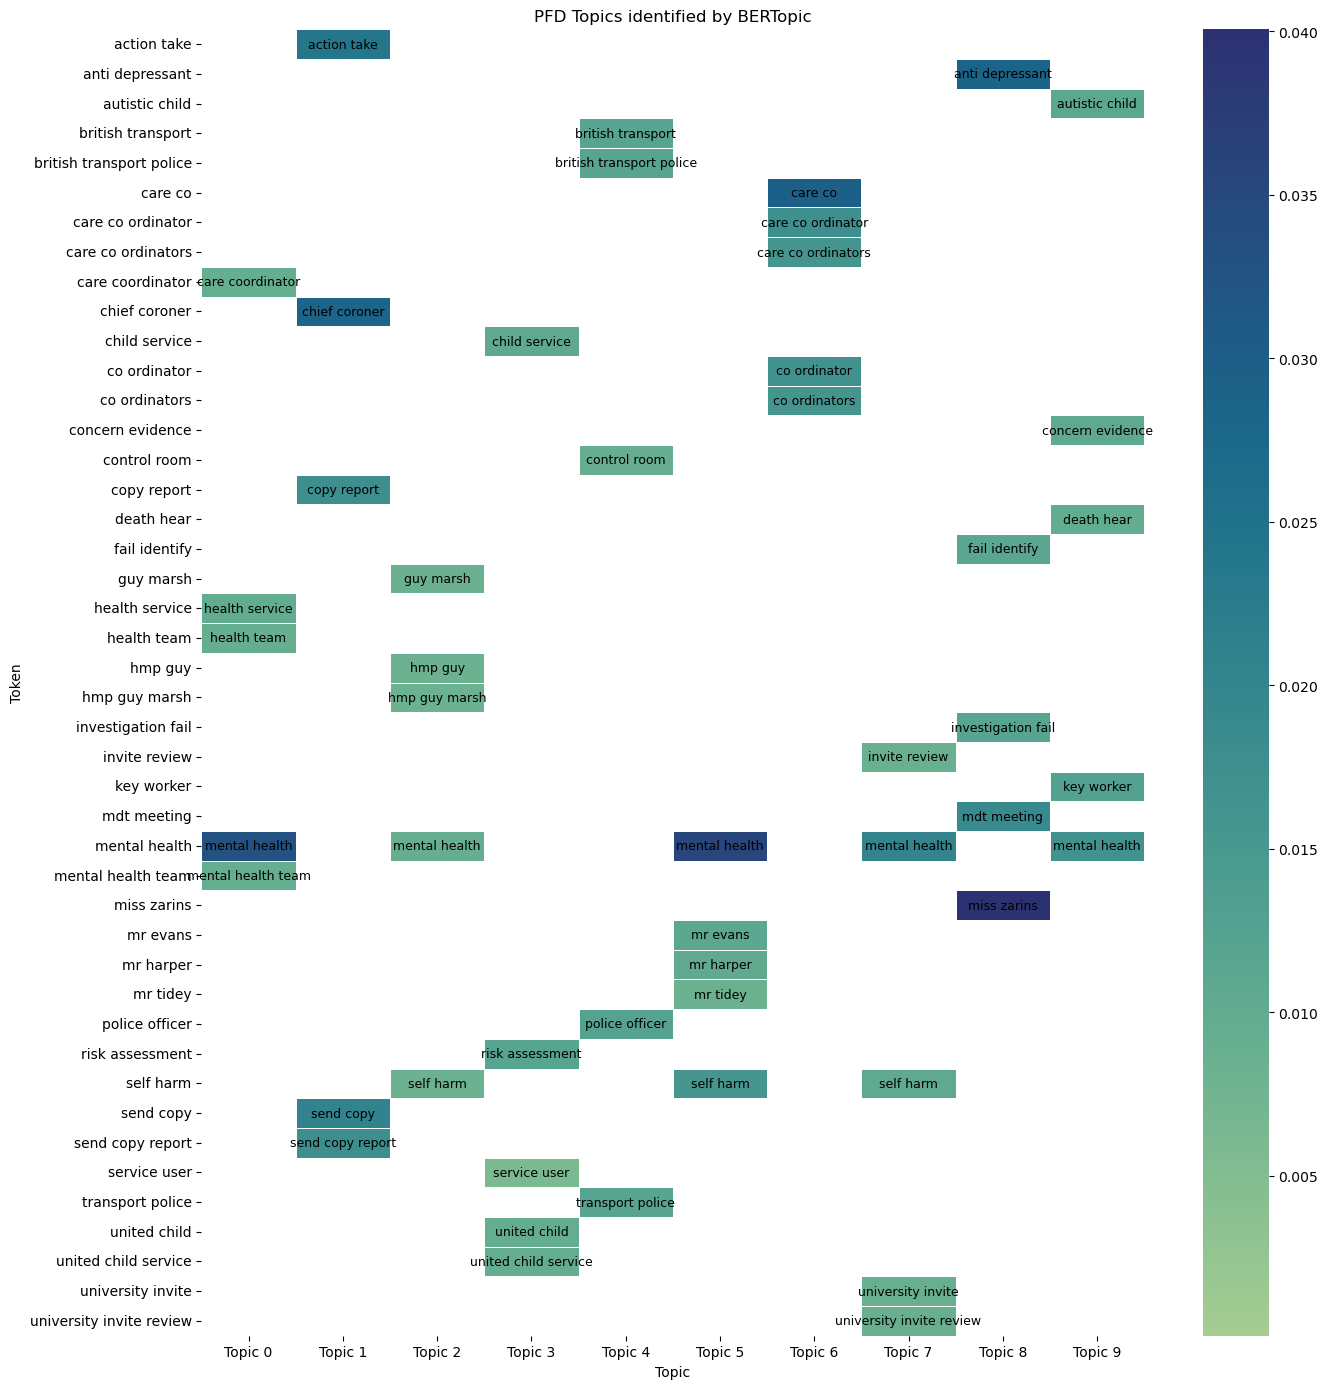

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize DataFrame to store topics data
topics_data = []

# Get unique topics
unique_topics = set(topics)

# Iterate over each unique topic and store the topic data in a DataFrame
for topic_id in unique_topics:
    if topic_id != -1:  # Skip the outlier topic if it exists (reflected through "-1")
        topic_words = bertopic_model.get_topic(topic_id)
        topic_df = pd.DataFrame(topic_words, columns=['Word', 'Probability'])
        topic_df['Topic'] = f'Topic {topic_id}'
        topics_data.append(topic_df)

# Concatenate all topics data into a single DataFrame
topics_df = pd.concat(topics_data, ignore_index=True)

# Check the topics_df content
print(topics_df.head())

# Reshape data from topics DataFrame
reshaped_data = topics_df.rename(columns={'Word': 'Bigram', 'Probability': 'Prob'})

# Set 'Bigram' as index
reshaped_data.set_index('Bigram', inplace=True)

# Create pivot table for heatmap
pivot_table = reshaped_data.pivot(columns='Topic', values='Prob').fillna(0)

# Check the pivot_table content
print(pivot_table.head())

# Plot heatmap
plt.figure(figsize=(14, 14))
cmap = sns.color_palette("crest", as_cmap=True)
cmap.set_under(color='white')

# Generate heatmap
sns.heatmap(pivot_table, cmap=cmap, linewidths=0.5, annot=False,
            cbar=True, mask=(pivot_table == 0), vmin=0.0001)

# Add bigrams with non-zero probability on top of the heatmap
for i, bigram in enumerate(pivot_table.index):
    for j, topic in enumerate(pivot_table.columns):
        if pivot_table.loc[bigram, topic] > 0:
            plt.text(j + 0.5, i + 0.5, bigram, ha='center', va='center',
                     color='black' if pivot_table.loc[bigram, topic] > 0 else 'white', fontsize=9)

# Customize plot
plt.title('PFD Topics identified by BERTopic')
plt.xlabel('Topic')
plt.ylabel('Token')
plt.tight_layout()
plt.show()


### Final thoughts

* Anecdotally, the model seems to have produced *some* coherent topics. For example, even without inspecting the report URLs, we can see that Topic 4 is concerned with suicide on the railways (this is a known high-risk location for suicide).
* It looks like our preprocessing notebook failed to completely remove template text. This can be seen through trigrams such as "concern evidence". I've tried hard to experiment with this by increasing the context window of the GPT model and by prompt engineering, but this has not been successful so far. We might be confined by the limits of the GPT 3.5 model here - though GPT 4 is significantly more expensive to run.
* It also looks like the use of individual names (e.g. "Miss Zarins") has created some noise and thrown off the coherence of topics. I did attempt to use the GPT model to remove these names, but this meant increasing the model's context window to the entire report, causing it to perform very badly on its primary task of removing the template text. GPT 3.5 is notoriously bad with large prompts. The new "GPT 4-o" likely excels here, but it's too pricey.
* I also wonder whether the identified "topics" are actually not as interesting as the identified bigrams and trigrams themselves - i.e. is looking at the occurance of these more interesting and/or meaningful than the identified topics?